In [1]:
import numpy as np
import sep

The cell above is used to import libraries that do tasks. Sep is a library that estimates backgrounds, detects objects, and performs photometry. 

In [2]:
from astropy.io import fits
from astropy.utils.data import download_file

This imports Astropys FITS file reader which is used to open astronomy image files, and download_file imports a tool that downloads a file from the internet and saves it locally

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

importing the plotting library and plot configuration settings

In [4]:
rcParams['figure.figsize'] = [10., 8.]

Sets the default figure size for all plots to be 10 by 8 inches

In [5]:
url_1 = 'https://archive.stsci.edu/pub/hlsp/hudf12/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'
local_path = download_file(url_1, cache=True)

stores the web address of thr FITS image and then downloads the file onto your computer and saves it locally

In [6]:

with fits.open(local_path, memmap=False) as hdul:
    data = hdul[0].data.astype(np.float32)


if not data.dtype.isnative:
    data = data.astype(data.dtype.newbyteorder('='))


Opens the fits file and extracts the image matrix and converts it to 32 bit floating point numbers to then store it in data as a 2-D NumPy array using astropy

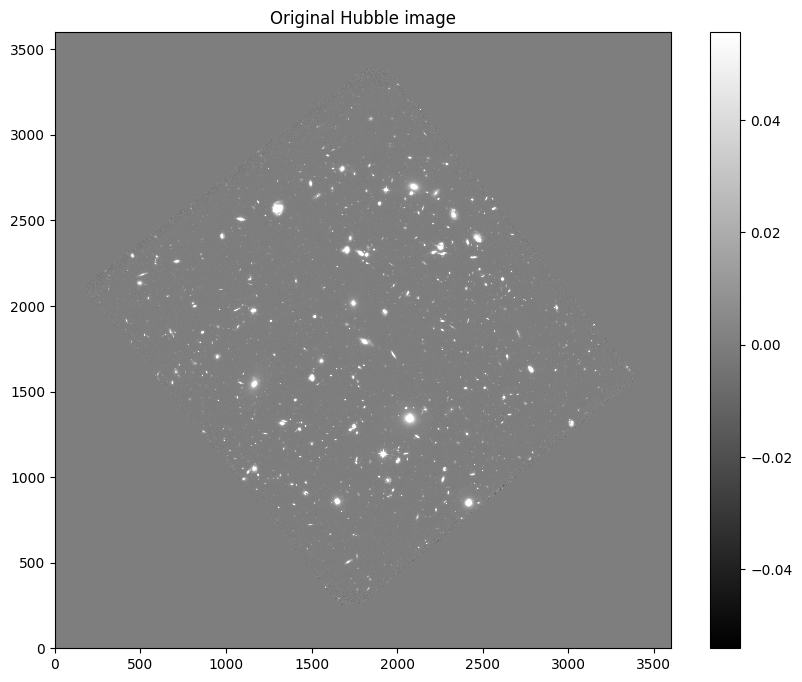

In [7]:


m, s = np.mean(data), np.std(data)
plt.figure()
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title('Original Hubble image')
plt.savefig('figure_1_original_image_hubble.png')
plt.show()



creates a blank plot that displays the image in grayscale with good contrast, correct orientation, labeled title, and saves it as a PNG

In [8]:
bkg = sep.Background(data) 

Creates a background model of the image

In [9]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


prints the avergae background prightness and background noise level

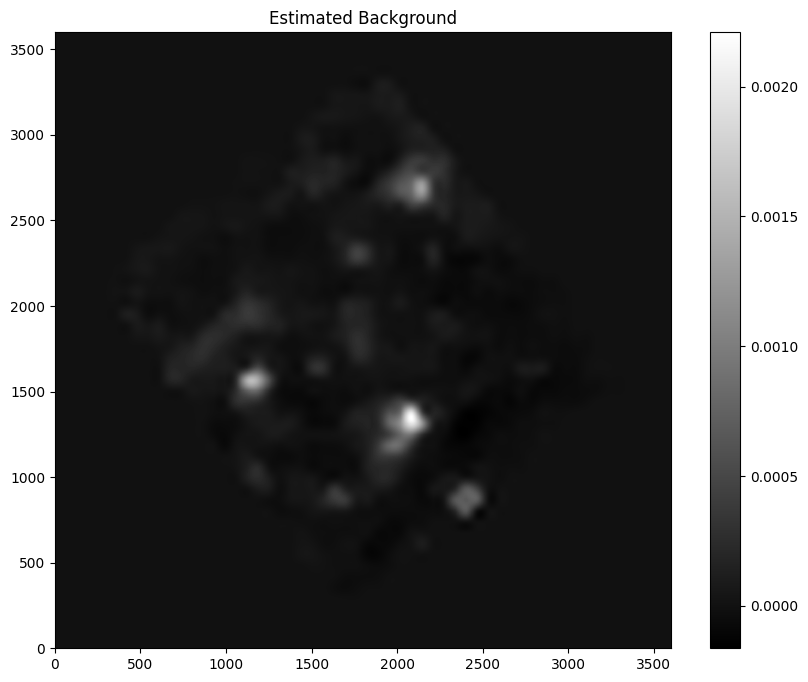

In [10]:

bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Estimated Background')
plt.savefig('figure_2_background_hubble.png')
plt.show()

creates and displays a 2D background image

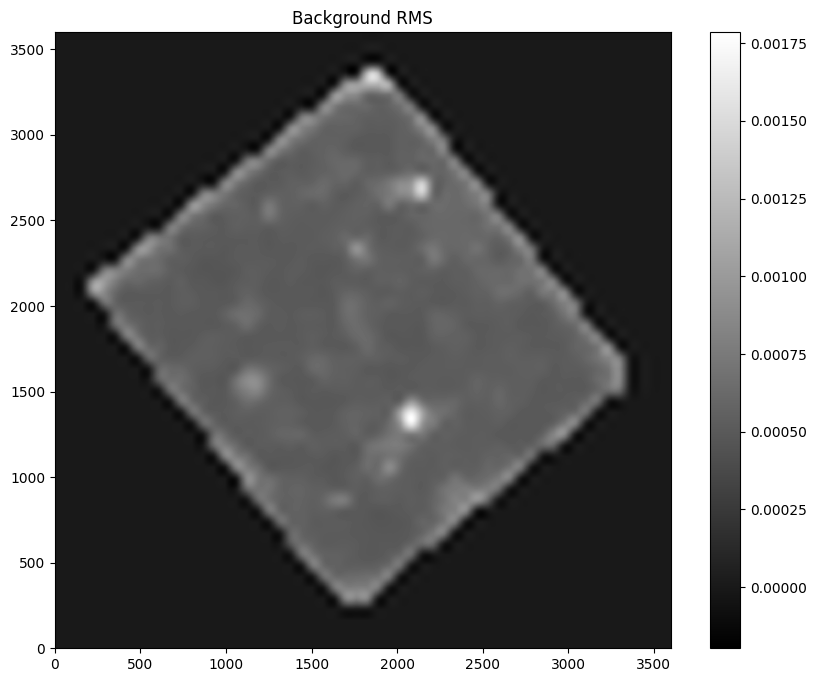

In [11]:

bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background RMS')
plt.savefig('figure_3_background_rms_hubble.png')
plt.show()

Creates and displays the noise map of the image

In [12]:
data_sub = data - bkg

subtracts the background from the image so only the real objects are left

In [13]:
objects = sep.extract(data_sub, 3.0, err=bkg.globalrms)
len(objects)
print(f"number of sources detected: {len(objects)}")

number of sources detected: 4349


detects objects using a threshold of 3.0x noise and outputs how many objects were found

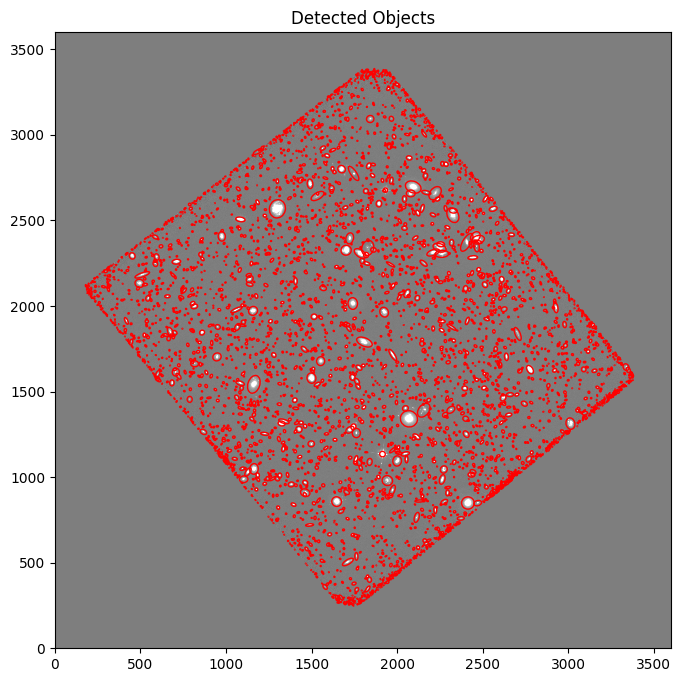

In [14]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.title('Detected Objects')
plt.savefig('figure_4_detected_objects_hubble.png')
plt.show()

Creates a loop through every detected object , sets ellipse center at the objects coordinates and makes it hollow and  to draw it on the image

In [15]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Lists all physical measurments returned for each object

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.029831 +/- 0.172742
object 1: flux = 0.085622 +/- 0.292626
object 2: flux = 0.026933 +/- 0.164137
object 3: flux = 0.046099 +/- 0.214727
object 4: flux = 0.064379 +/- 0.253747
object 5: flux = 0.070986 +/- 0.266448
object 6: flux = 0.026083 +/- 0.161527
object 7: flux = 0.104682 +/- 0.323559
object 8: flux = 0.044953 +/- 0.212041
object 9: flux = 0.042711 +/- 0.206686


This measures the light intensity inside a 3-pixel radius around each object, loops it through the first 10 objects, then prints the object number, measured light, + photometry uncertainty.

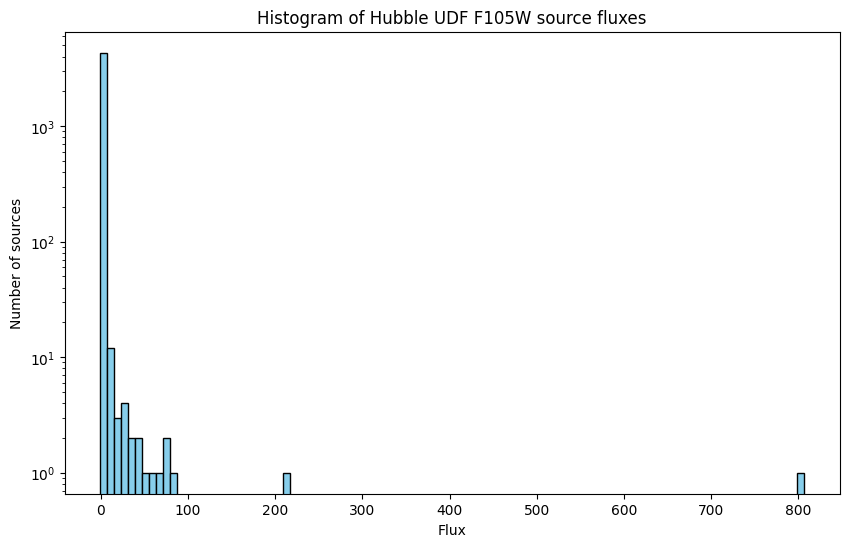

In [17]:
plt.figure(figsize=(10,6))
plt.hist(flux, bins=100, log=True, color='skyblue', edgecolor='black')
plt.xlabel('Flux')
plt.ylabel('Number of sources')
plt.title('Histogram of Hubble UDF F105W source fluxes')
plt.show()

In [18]:
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)

In [19]:

max_flux_index = np.argmax(flux)
max_flux_value = flux[max_flux_index]
max_flux_x = objects['x'][max_flux_index]
max_flux_y = objects['y'][max_flux_index]
sigma_from_mean = (max_flux_value - flux_mean) / flux_std

Identify the largets outlier

In [20]:
print(f"Flux mean: {flux_mean}")
print(f"Flux median: {flux_median}")
print(f"Flux std: {flux_std}")
print(f"Largest flux: {max_flux_value}")
print(f"Largest flux position (x, y): ({max_flux_x}, {max_flux_y})")
print(f"Largest flux is {sigma_from_mean:.2f} sigma above the mean")

Flux mean: 0.7040430645638499
Flux median: 0.07352971739572241
Flux std: 13.01835009130945
Largest flux: 807.1093853378296
Largest flux position (x, y): (1914.2580652413892, 1134.3147121014981)
Largest flux is 61.94 sigma above the mean


In [21]:
url_2 = 'https://archive.stsci.edu/pub/hlsp/hudf12/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits'
url_3 = 'https://archive.stsci.edu/pub/hlsp/hudf12/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits'

In [22]:
local_105 = download_file(url_1, cache=True)
local_125 = download_file(url_2, cache=True)
local_160 = download_file(url_3, cache=True)

files = {
    'f105w': local_105,
    'f125w': local_125,
    'f160w': local_160
}

data = {}
for band, fname in files.items():
    with fits.open(fname) as hdul:
        img = hdul[0].data.astype(float)
        data[band] = img
        print(f"Loaded {band}: shape={img.shape}")

def stretch(img, lo=0.5, hi=99.5):
    vmin, vmax = np.percentile(img, (lo, hi))
    img_clipped = np.clip(img, vmin, vmax)
    return (img_clipped - vmin) / (vmax - vmin)


Loaded f105w: shape=(3600, 3600)
Loaded f125w: shape=(3600, 3600)
Loaded f160w: shape=(3600, 3600)


 Create normalized R, G, B arrays

In [23]:
R = stretch(data['f160w'])   
G = stretch(data['f125w'])  
B = stretch(data['f105w'])  

RGB = np.dstack([R, G, B])

plt.figure(figsize=(10, 10))
plt.imshow(RGB, origin='lower')
plt.axis('off')
plt.savefig("HUDF_false_color.png", dpi=300, pad_inches=0)
plt.close()

print("Saved HUDF_false_color.png")


Saved HUDF_false_color.png
